<a href="https://colab.research.google.com/github/wkdth04/hanghae99AI3th/blob/1%EC%A3%BC%EC%B0%A8-%EA%B3%BC%EC%A0%9C/1_3_MNIST_%EA%B3%BC%EC%A0%9C_%EC%9E%A5%EC%86%8C%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.


# 기본실습 과제
MNIST를 regression model이 아닌 classicication model로 구현하기
train과 test data에 대한 모델 정확도를 plot 하여 generalization error 살펴보기

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#정확도 측정하는 함수 추가
def accuracy(model, dataloader):
  cnt = 0
  acc = 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=1) #argmax로 최종 예측값 선택

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc /cnt #정확도 계산

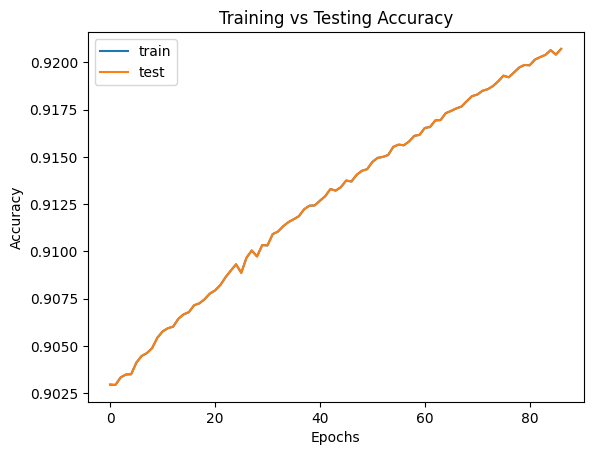

In [ ]:
#정확도 시각화 함수 추가
def plot_acc(train_accs, test_accs):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label='train')
    plt.plot(x, test_accs, label='test')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Testing Accuracy")
    plt.show()

# 정확도 그래프 출력
plot_acc(train_accs, test_accs)

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
#테스트 셋 train false로 변경
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform)

In [ ]:
batch_size = 256

#DataLoader는 데이터를 미니 배치 단위로 나누어 로드함
#학습 데이터는 무작위로 섞어줌
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

#테스트 데이터는 랜덤필요없음 -> False
testloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=False)

60000
torch.Size([1, 28, 28]) 5


<function matplotlib.pyplot.show(close=None, block=None)>

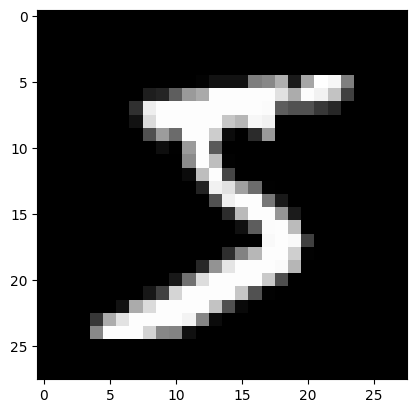

In [ ]:

# 첫 번째 데이터의 이미지와 레이블 출력
#plt.imshow()는 첫 번째 이미지를 출력하여 손글씨 숫자가 어떻게 생겼는지 보여줌
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')
plt.show

In [ ]:
'''dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)'''

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [ ]:
# 모델정의
from torch import nn

# 출력 차원 변경(10클래스)
class Model(nn.Module):
  def __init__(self, input_dim, n_dim, num_classes=10): #num_classes추가
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, num_classes) #기존 1을 num_classes 개수(10)로 변경
    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) #CrossEntropyLoss를 사용하기 때문에 softmax 적용 X
    return x


model = Model(28 * 28 * 1, 1024)

In [ ]:
#SGD 는 경사하강법 기반의 옵티마이저 설정하는 부분
#model.parameters()는 모델의 모든 학습 가능한 파라미터를 옵티마이저에 전달
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [ ]:
#학습
n_epochs = 100
#CrossEntropyLoss 적용
loss_fn = nn.CrossEntropyLoss() # 손실함수 변경

#학습 루프
train_accs = [] #train 정확도 저장 리스트
test_accs = [] #test 정확도 저장 리스트

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # loss = (preds[:, 0] - labels).pow(2).mean() -> MSE
    loss = loss_fn(preds,labels) # CrossEntropyLoss 적용

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

# accuracy(model, trainloader) -> 정확도 측정함수
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)
#매 Epoch마다 정확도 저장 (train_accs, test_accs 리스트 추가)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")
'''
#기존 실습내용
#예측 및 손실 계산
#기존 회귀함수 MSE를 CrossEntropyLoss로 바꾸기
     preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean() # MSE Loss 적용부분
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
'''

Epoch   0 | Loss: 174.19369053840637
Epoch   1 | Loss: 168.4114532470703
Epoch   2 | Loss: 163.0412826538086
Epoch   3 | Loss: 158.19069695472717
Epoch   4 | Loss: 153.89660453796387
Epoch   5 | Loss: 149.82797574996948
Epoch   6 | Loss: 146.07556158304214
Epoch   7 | Loss: 142.68936491012573
Epoch   8 | Loss: 139.41254630684853
Epoch   9 | Loss: 136.50063836574554
Epoch  10 | Loss: 133.7724943459034
Epoch  11 | Loss: 131.24543404579163
Epoch  12 | Loss: 128.91976940631866
Epoch  13 | Loss: 126.59623935818672
Epoch  14 | Loss: 124.6121928691864
Epoch  15 | Loss: 122.5400101840496
Epoch  16 | Loss: 120.72071653604507
Epoch  17 | Loss: 118.95693415403366
Epoch  18 | Loss: 117.22209140658379
Epoch  19 | Loss: 115.7220090329647
Epoch  20 | Loss: 114.20214587450027
Epoch  21 | Loss: 112.79936930537224
Epoch  22 | Loss: 111.52345389127731
Epoch  23 | Loss: 110.16978794336319
Epoch  24 | Loss: 108.94460460543633
Epoch  25 | Loss: 107.85549536347389
Epoch  26 | Loss: 106.68458208441734
Epoch  

'\n#기존 실습내용\n#예측 및 손실 계산\n#기존 회귀함수 MSE를 CrossEntropyLoss로 바꾸기\n     preds = model(inputs)\n    loss = (preds[:, 0] - labels).pow(2).mean() # MSE Loss 적용부분\n    loss.backward()\n    optimizer.step()\n    total_loss += loss.item()\n'

In [ ]:
print(accuracy(model, trainloader))
print(accuracy(model, testloader))

0.9098
0.9098


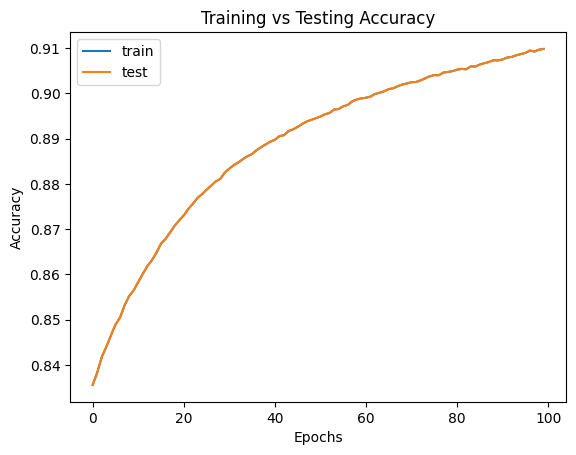

In [ ]:
plot_acc(train_accs, test_accs)